## Convert the LOS angles into the unit vectors

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
plt.rcParams.update({'font.size': 12})

dnames = [
    'S1_D033_20250319_20250331_OFF_AZ',
    'S1_D033_20250319_20250331_OFF_RG',
]

In [2]:
def get_los_name(dname):
    suffix = dname.split('_')[-1]
    if suffix in ['IFG', 'RG']:
        los_name = 'rg'
    elif suffix in ['MAI', 'AZ']:
        los_name = 'az'
    else:
        raise ValueError(f'Un-recognized LOS direction for {dname}!')
    print(f'observation LOS direction: {los_name}')
    return los_name

def los_file2enu_file(los_name, los_file, enu_file, update_mode=True):
    if update_mode and os.path.isfile(enu_file):
        print(f'ENU file ({enu_file}) exists, skip re-generating.')
        # plot
        ve = readfile.read(enu_file, datasetName='band1')[0]
        vn = readfile.read(enu_file, datasetName='band2')[0]
        vu = readfile.read(enu_file, datasetName='band3')[0]
        plot_enu_vectors(ve, vn, vu)
        return

    # read
    atr = readfile.read_attribute(los_file)
    length, width = int(atr['LENGTH']), int(atr['WIDTH'])
    inc_angle = readfile.read(los_file, datasetName='incidenceAngle')[0]
    az_angle = readfile.read(los_file, datasetName='azimuthAngle')[0]

    # calc unit vectors
    if los_name == 'rg':
        # cross-track direction: positive for range increase (moving away from satellite)
        ve = np.sin(np.deg2rad(inc_angle)) * np.sin(np.deg2rad(az_angle))
        vn = np.sin(np.deg2rad(inc_angle)) * np.cos(np.deg2rad(az_angle)) * -1
        vu = np.cos(np.deg2rad(inc_angle)) * -1
    else:
        # along-track direction: positive for moving toward the flight direction
        orb_az_angle = ut.los2orbit_azimuth_angle(az_angle)
        ve = np.sin(np.deg2rad(orb_az_angle)) * -1
        vn = np.cos(np.deg2rad(orb_az_angle))
        vu = np.zeros((length, width), dtype=np.float32)

    # plot
    plot_enu_vectors(ve, vn, vu)

    # write
    data = np.hstack((ve, vn, vu), dtype=np.float32)
    print(f'write file: {enu_file}')
    data.tofile(enu_file)
    atr['FILE_TYPE'] = 'unit_vector'
    atr['BANDS'] = '3'
    atr['INTERLEAVE'] = 'BIL'
    atr['DATA_TYPE'] = 'float32'
    writefile.write_isce_xml(atr, enu_file)
    writefile.write_roipac_rsc(atr, enu_file+'.rsc')
    return enu_file


def plot_enu_vectors(ve, vn, vu):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 5], sharey=True)
    for ax, data, title in zip(axs, [ve, vn, vu], ['east', 'north', 'up']):
        im = ax.imshow(data, interpolation='nearest')
        ax.set_title(title)
        fig.colorbar(im, ax=ax, orientation='horizontal')
    plt.show()
    return


print('wram up functions.')

wram up functions.


--------------------------------------------------1/2
prepare ENU vectors for S1_D033_20250319_20250331_OFF_AZ
Go to directory: /Users/yunjunz/data/archives/2025MandalayEQ/data/S1_D033_20250319_20250331_OFF_AZ
observation LOS direction: az


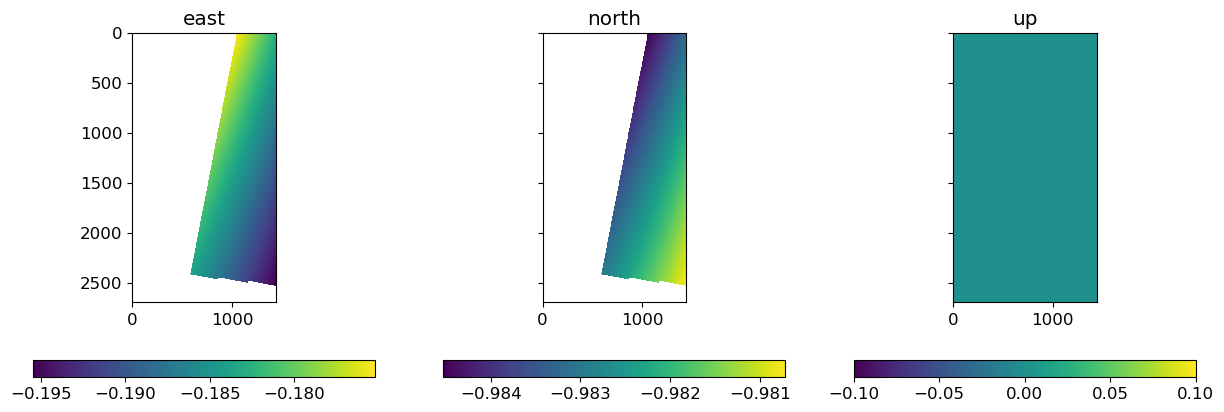

write file: /Users/yunjunz/data/archives/2025MandalayEQ/data/S1_D033_20250319_20250331_OFF_AZ/enu.geo
write file: /Users/yunjunz/data/archives/2025MandalayEQ/data/S1_D033_20250319_20250331_OFF_AZ/enu.geo.xml
write file: /Users/yunjunz/data/archives/2025MandalayEQ/data/S1_D033_20250319_20250331_OFF_AZ/enu.geo.vrt
--------------------------------------------------2/2
prepare ENU vectors for S1_D033_20250319_20250331_OFF_RG
Go to directory: /Users/yunjunz/data/archives/2025MandalayEQ/data/S1_D033_20250319_20250331_OFF_RG
observation LOS direction: rg


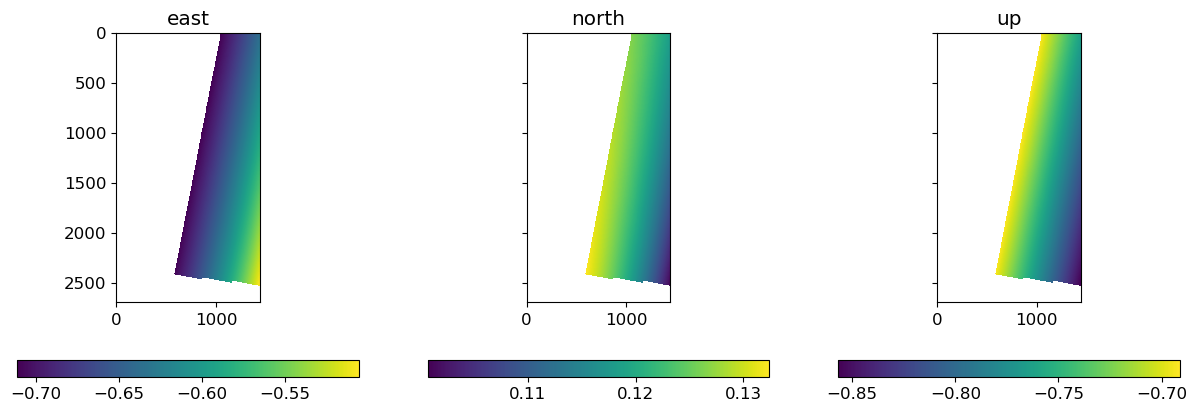

write file: /Users/yunjunz/data/archives/2025MandalayEQ/data/S1_D033_20250319_20250331_OFF_RG/enu.geo
write file: /Users/yunjunz/data/archives/2025MandalayEQ/data/S1_D033_20250319_20250331_OFF_RG/enu.geo.xml
write file: /Users/yunjunz/data/archives/2025MandalayEQ/data/S1_D033_20250319_20250331_OFF_RG/enu.geo.vrt


In [3]:
update_mode = True
for i, dname in enumerate(dnames):
    print('-'*50 + f'{i+1}/{len(dnames)}')
    print(f'prepare ENU vectors for {dname}')

    # directory
    proj_dir = os.path.expanduser('~/data/archives/2025MandalayEQ')
    work_dir = os.path.join(proj_dir, 'data', dname)
    os.chdir(work_dir)
    print('Go to directory:', work_dir)

    # input / output files
    los_file = os.path.join(work_dir, 'los.geo')
    enu_file = os.path.join(work_dir, 'enu.geo')

    # run
    los_name = get_los_name(dname)
    los_file2enu_file(los_name, los_file, enu_file, update_mode=update_mode)